In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics ensemble_boxes
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torchvision.ops import nms
from ultralytics import YOLO
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from ensemble_boxes import weighted_boxes_fusion
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    return transform

In [ ]:
class DOTADETECTION(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "DOTA_1.5.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]


    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, "images", path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        h, w, _ = image.shape

        normalized_boxes = []
        for box in boxes:
            x_min = box[0] / w
            y_min = box[1] / h
            x_max = (box[0] + box[2]) / w
            y_max = (box[1] + box[3]) / h
            normalized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min, box[4]])

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=normalized_boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        denormalized_boxes = []
        for box in boxes:
            x_min = box[0] * w
            y_min = box[1] * h
            x_max = (box[0] + box[2]) * w
            y_max = (box[1] + box[3]) * h
            denormalized_boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.tensor(denormalized_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] + 1 for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ

    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/MyDrive/dota_dataset"

In [ ]:
classes = ['plane',
 'baseball-diamond',
 'bridge',
 'ground-track-field',
 'small-vehicle',
 'large-vehicle',
 'ship',
 'tennis-court',
 'basketball-court',
 'storage-tank',
 'soccer-ball-field',
 'roundabout',
 'harbor',
 'swimming-pool',
 'helicopter',
 'container-crane']

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
test_dataset = DOTADETECTION(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=2.49s)
creating index...
index created!


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = torch.load(dataset_path + "/models/test(75).pth")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
img, _ = test_dataset[110]
img_int = torch.tensor(img*255, dtype=torch.uint8)
print(img_int.shape)
model.to(device)

total_boxes = 0
threshold = 0.8
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = {
        "boxes": prediction[0]["boxes"][prediction[0]["scores"] > threshold],
        "labels": prediction[0]["labels"][prediction[0]["scores"] > threshold],
        "scores": prediction[0]["scores"][prediction[0]["scores"] > threshold],
    }
    total_boxes = len(pred['boxes'])

print(total_boxes)

torch.Size([3, 512, 512])
100


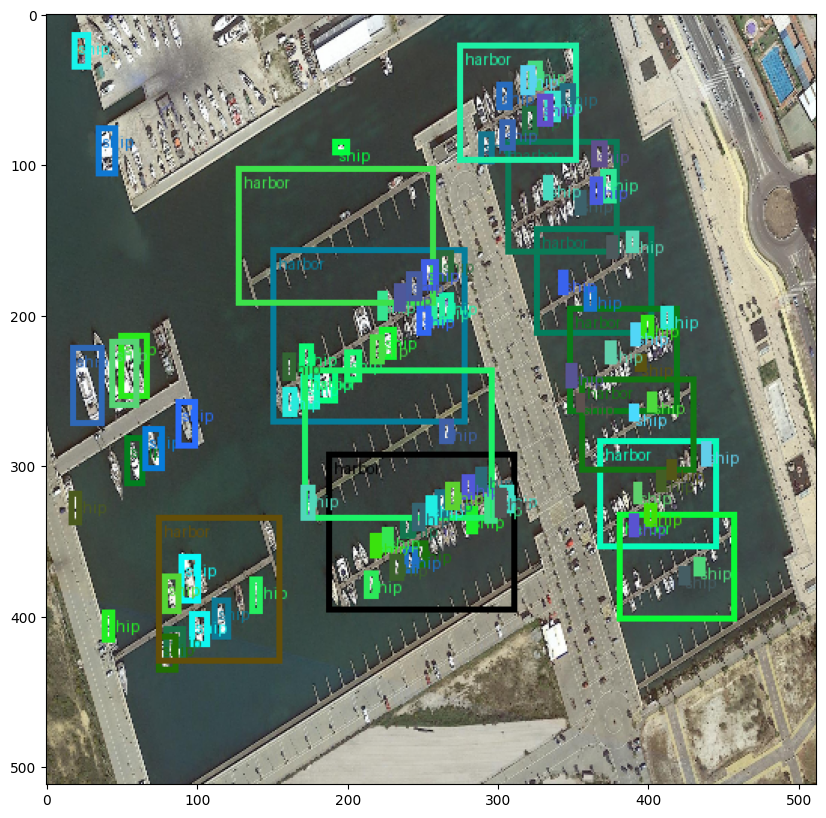

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > threshold],
    [classes[i] for i in pred['labels'][pred['scores'] > threshold].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
def compute_iou(box1, box2):
    """Compute IoU (Intersection over Union) between two bounding boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

In [ ]:
def compute_ap(recall, precision):
    """Compute Average Precision (AP) given precision and recall."""
    recall = np.concatenate(([0.], recall, [1.]))
    precision = np.concatenate(([0.], precision, [0.]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap

In [ ]:
def evaluate_map_recall(model, dataloader, device, iou_threshold=0, score_threshold=0):
    """Compute mAP and recall for the object detection model with score thresholding."""
    model.eval()
    all_ap = []
    all_recall = []
    iou_values = []
    per_class_ap = {}

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            imgs = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(imgs)

            for pred, target in zip(predictions, targets):
                gt_boxes = target["boxes"].cpu().numpy()
                pred_boxes = pred["boxes"].cpu().numpy()
                pred_scores = pred["scores"].cpu().numpy()
                pred_labels = pred["labels"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()

                # Apply score threshold
                valid_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[valid_indices]
                pred_labels = pred_labels[valid_indices]
                pred_scores = pred_scores[valid_indices]

                sorted_indices = np.argsort(-pred_scores)
                pred_boxes = pred_boxes[sorted_indices]
                pred_labels = pred_labels[sorted_indices]
                pred_scores = pred_scores[sorted_indices]

                tp = np.zeros(len(pred_boxes))
                fp = np.zeros(len(pred_boxes))
                matched_gt = set()

                for i, pred_box in enumerate(pred_boxes):
                    ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
                    max_iou = max(ious) if ious else 0
                    iou_values.append(max_iou)

                    if max_iou >= iou_threshold and ious.index(max_iou) not in matched_gt:
                        tp[i] = 1
                        matched_gt.add(ious.index(max_iou))
                    else:
                        fp[i] = 1

                cum_tp = np.cumsum(tp)
                cum_fp = np.cumsum(fp)
                recall = cum_tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
                precision = cum_tp / (cum_tp + cum_fp)

                ap = compute_ap(recall, precision)
                all_ap.append(ap)
                all_recall.append(recall[-1] if len(recall) > 0 else 0)

                # Store per-class AP
                for label in np.unique(gt_labels):
                    if label not in per_class_ap:
                        per_class_ap[label] = []
                    per_class_ap[label].append(ap)

    # Compute per-class mean AP
    per_class_map = {k: np.mean(v) for k, v in per_class_ap.items()}
    return np.mean(all_ap), np.mean(all_recall), per_class_map, iou_values

In [ ]:
mAP, recall, per_class_map, iou_values = evaluate_map_recall(model, test_loader, device=device)
print(f"\nmAP: {mAP:.4f}, Recall: {recall:.4f}")

# mAP: 0.5502, Recall: 0.6161
# 25 epochs: mAP: 0.5536, Recall: 0.6003
# 30 epochs: mAP: 0.5532, Recall: 0.6038
# 40 epochs: mAP: 0.5471, Recall: 0.5963
# 50 epochs: mAP: 0.5469, Recall: 0.5895
# 75 epochs: mAP: 0.5273, Recall: 0.5569

100%|██████████| 115/115 [03:47<00:00,  1.98s/it]


mAP: 0.5273, Recall: 0.5569


In [ ]:
# Plot Precision-Recall Curve
def plot_precision_recall(precision, recall):
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='o', linestyle='-', color='b', label="Precision-Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# IoU Distribution Histogram
def plot_iou_distribution(iou_values):
    plt.figure(figsize=(6, 5))
    plt.hist(iou_values, bins=20, color='b', alpha=0.7)
    plt.xlabel("IoU Value")
    plt.ylabel("Frequency")
    plt.title("IoU Distribution")
    plt.show()

In [ ]:
# mAP per Class Bar Plot
def plot_map_per_class(per_class_map):
    plt.figure(figsize=(8, 5))
    classes = list(per_class_map.keys())
    ap_values = list(per_class_map.values())
    plt.bar(classes, ap_values, color='purple', alpha=0.7)
    plt.xlabel("Class ID")
    plt.ylabel("mAP")
    plt.title("mAP per Class")
    plt.xticks(classes)
    plt.show()

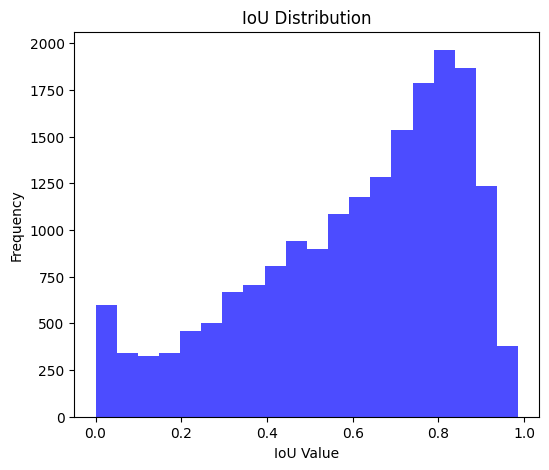

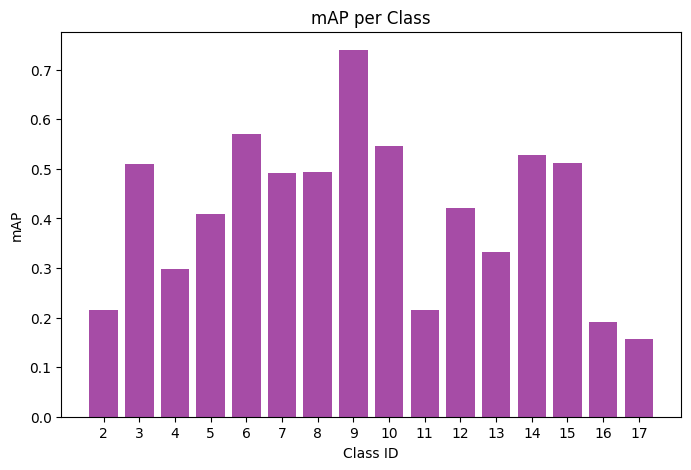

In [ ]:
iou_values = np.array(iou_values)
iou_values = iou_values[iou_values>0]

plot_iou_distribution(iou_values)
plot_map_per_class(per_class_map)

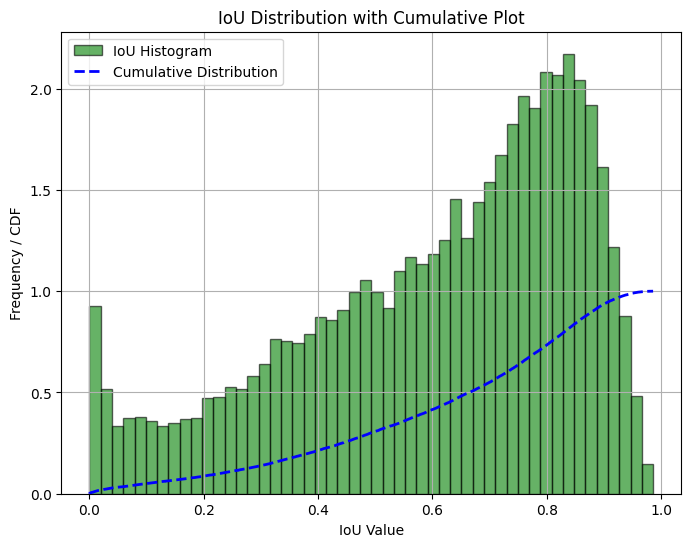

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

# Plot histogram
plt.hist(iou_values, bins=50, color='green', alpha=0.6, edgecolor='black', density=True, label='IoU Histogram')

# Plot cumulative distribution
sorted_iou = np.sort(iou_values)
cdf = np.arange(len(sorted_iou)) / float(len(sorted_iou))
plt.plot(sorted_iou, cdf, color='blue', linestyle='dashed', linewidth=2, label='Cumulative Distribution')

plt.xlabel('IoU Value')
plt.ylabel('Frequency / CDF')
plt.title('IoU Distribution with Cumulative Plot')
plt.legend()
plt.grid(True)

plt.show()